In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pickle
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score
from tqdm import tqdm

from sklearn.preprocessing import quantile_transform

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import sys  
sys.path.insert(1, '/Users/rikardforlin/Forskning/EMD_annotationmodel/BLC_publication_FinalFigures/') #insert path to root directory

# Sample with noise:

In [ ]:
clf_path = '../../classifier/BLC_classifier_maxdepth30_maxgenes70n_estimators200_thres0.4_minsampleleaf20.pickle'

folder_location = '../../classifiers_results/noisy_genes/'
all_data_paths = ['insert all data paths here']

set_lambda = 1

with open(clf_path, 'rb') as handle:
    clf = pickle.load(handle)
for data_path in all_data_paths:
    if not '.h5ad' in data_path:
        continue
    print(data_path)
        
    test_ad = sc.read('/Users/rikardforlin/Forskning/Data/ForEMD_publication/test_classify_datasets/' + data_path)
    
    sc.pp.normalize_total(test_ad, target_sum = 1e4)
    test_samples_original = test_ad.to_df()
    all_markergenes = []

    for key in clf.classifiers.keys():
        all_markergenes += clf.classifiers[key].features_
    all_markergenes = list(set(all_markergenes))
    test_samples_original = test_samples_original[test_samples_original.columns[test_samples_original.columns.isin(all_markergenes)]]
    toshuffle_genes = pd.Series(all_markergenes)
    toshuffle_genes = toshuffle_genes[toshuffle_genes.isin(test_samples_original.columns)]
    
    f1_scores_permutated = pd.DataFrame()
    for i in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        f1_scores = []
        for j in tqdm(range(0,100)):
            #Sample markergenes
            test_samples = test_samples_original.copy()
            sampled = list(toshuffle_genes.sample(int(len(toshuffle_genes)*i)))
            df_shuffledgenes = test_samples[test_samples.columns[test_samples.columns.isin(sampled)]]
            
            for c in df_shuffledgenes.columns:
                #df_shuffledgenes[c] = df_shuffledgenes[c] + np.random.poisson(0, high = 2, size = len(df_shuffledgenes)) #add noise from uniform distribution
                df_shuffledgenes[c] = df_shuffledgenes[c] + np.random.poisson(lam = set_lambda, size = len(df_shuffledgenes)) #add noise from poisson distribution
            
            test_samples[df_shuffledgenes.columns] = df_shuffledgenes.values

            test_samples_scaled = quantile_transform(test_samples, n_quantiles=500)
            test_samples_scaled = pd.DataFrame(test_samples_scaled, index = test_samples.index, columns = test_samples.columns)

            test_correct_labels = test_ad.obs.CellType
            y_pred = clf.predict(test_samples_scaled)
            y_pred['actual_ct'] = test_correct_labels.values
            f1_scores += [np.round(f1_score(y_pred.ct_pred, y_pred.actual_ct, average = 'micro'), 3)]
            
        temp = pd.DataFrame({'f1_scores':f1_scores, 'perc_withaddednoise':i, 'dataset': data_path.split('.h5ad')[0]})
        f1_scores_permutated = pd.concat([temp, f1_scores_permutated])
        f1_scores_permutated.to_csv(folder_location +'addednoise_lambda1' + data_path.split('.h5ad')[0] + 'part1.csv')


# Plot Noisy genes

### Noisy genes with λ = 1

In [4]:
#Smartseq
#shufg = pd.read_csv('../../classifiers_results/noisy_genes/addednoise_lambda1SmartSeq3.csv')

#Lee HC
#shufg = pd.read_csv('../../classifiers_results/noisy_genes/addednoise_lambda1Lee_et_al_Science_HConly.csv')

#Lee Covid
shufg = pd.read_csv('../../classifiers_results/noisy_genes/addednoise_lambda1Lee_et_al_Science_Covidonly.csv')

#Oelen et al:
#shufg = pd.read_csv('../../classifiers_results/noisy_genes/addednoise_lambda1Oelen.csv')


In [5]:
opf = shufg[shufg.perc_withaddednoise == 0.05]
opo = shufg[shufg.perc_withaddednoise == 0.1]
opfif = shufg[shufg.perc_withaddednoise == 0.15]
opt = shufg[shufg.perc_withaddednoise == 0.2]
optf = shufg[shufg.perc_withaddednoise == 0.25]
opth = shufg[shufg.perc_withaddednoise == 0.3]

Text(0.5, 1.0, 'Lee Covid - f1-score with noise')

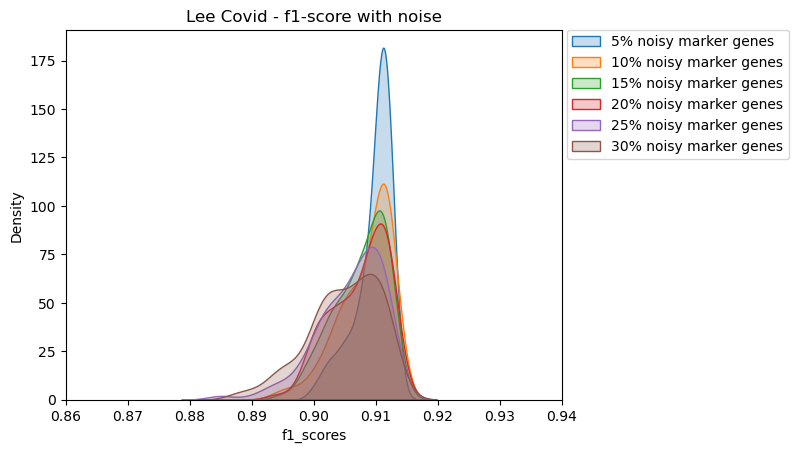

In [6]:
sns.kdeplot(opf.f1_scores, fill = True, label = '5% noisy marker genes')
sns.kdeplot(opo.f1_scores, fill = True, label = '10% noisy marker genes')
sns.kdeplot(opfif.f1_scores, fill = True, label = '15% noisy marker genes')
sns.kdeplot(opt.f1_scores, fill = True, label = '20% noisy marker genes')
sns.kdeplot(optf.f1_scores, fill = True, label = '25% noisy marker genes')
sns.kdeplot(opth.f1_scores, fill = True, label = '30% noisy marker genes')
plt.legend(loc = [1.01, 0.65])
plt.xlim(0.86, 0.94)
plt.title('Lee Covid - f1-score with noise')
#plt.xlim(0.8, 0.975)
#plt.savefig('LeeCov_noise_resistance.svg', bbox_inches = 'tight', format = 'svg', dpi = 200)

# Downsample genes

In [ ]:
clf_path = '../../classifier/BLC_classifier_maxdepth30_maxgenes70n_estimators200_thres0.4_minsampleleaf20.pickle'

folder_location = '../../classifiers_results/downsampled_genes/'

all_data_paths = ['insert all data paths here']


for data_path in all_data_paths:
    if not '.h5ad' in data_path:
        continue
    print(data_path)
        
    test_ad = sc.read('/Users/rikardforlin/Forskning/Data/ForEMD_publication/test_classify_datasets/' + data_path)
    
    sc.pp.normalize_total(test_ad, target_sum = 1e4)

    test_samples_original = test_ad.to_df()
    all_markergenes = []

    for key in clf.classifiers.keys():
        all_markergenes += clf.classifiers[key].features_
    all_markergenes = list(set(all_markergenes))
    test_samples_original = test_samples_original[test_samples_original.columns[test_samples_original.columns.isin(all_markergenes)]]
    toshuffle_genes = pd.Series(all_markergenes)
    toshuffle_genes = toshuffle_genes[toshuffle_genes.isin(test_samples_original.columns)]
    
    f1_scores_permutated = pd.DataFrame()
    for i in [0.05, 0.1, 0.15, 0.2, 0.25, 0.3]:
        f1_scores = []
        for j in tqdm(range(0,100)):
        
            #Sample markergenes
            test_samples = test_samples_original.copy()
            sampled = list(toshuffle_genes.sample(int(len(toshuffle_genes)*i)))
            #test_samples = test_samples[test_samples.columns[~test_samples.columns.isin(sampled)]]
            test_samples[sampled] = 0
            
            test_samples_scaled = quantile_transform(test_samples, n_quantiles=500)
            test_samples_scaled = pd.DataFrame(test_samples_scaled, index = test_samples.index, columns = test_samples.columns)

            test_correct_labels = test_ad.obs.CellType
            y_pred = clf.predict(test_samples_scaled)
            y_pred['actual_ct'] = test_correct_labels.values
            f1_scores += [np.round(f1_score(y_pred.ct_pred, y_pred.actual_ct, average = 'micro'), 3)]
            
        temp = pd.DataFrame({'f1_scores':f1_scores, 'perc_deleted':i, 'dataset': data_path.split('.h5ad')[0]})
        f1_scores_permutated = pd.concat([temp, f1_scores_permutated])
        f1_scores_permutated.to_csv(folder_location +'deleted_genes' + data_path.split('.h5ad')[0] + 'part2.csv')



# Plot downsampled genes

In [7]:
#Smartseq
#shufg = pd.read_csv('../../classifiers_results/downsampled_genes/deleted_genesSmartSeq3.csv')

#Lee HC
#shufg = pd.read_csv('../../classifiers_results/downsampled_genes/deleted_genesLee_et_al_Science_HConly.csv')

#Lee Covid
shufg = pd.read_csv('../../classifiers_results/downsampled_genes/deleted_genesLee_et_al_Science_Covidonly.csv')

#Oelen et al:
#shufg = pd.read_csv('../../classifiers_results/downsampled_genes/deleted_genesOelen.csv')


In [8]:
opf = shufg[shufg.perc_deleted == 0.05]
opo = shufg[shufg.perc_deleted == 0.1]
opfif = shufg[shufg.perc_deleted == 0.15]
opt = shufg[shufg.perc_deleted == 0.2]
optf = shufg[shufg.perc_deleted == 0.25]
opth = shufg[shufg.perc_deleted == 0.3]

(0.8, 0.975)

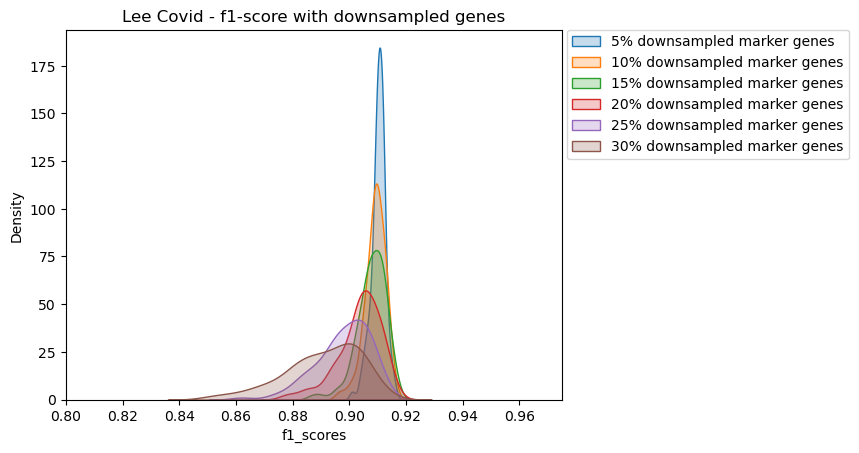

In [9]:
sns.kdeplot(opf.f1_scores, fill = True, label = '5% downsampled marker genes')
sns.kdeplot(opo.f1_scores, fill = True, label = '10% downsampled marker genes')
sns.kdeplot(opfif.f1_scores, fill = True, label = '15% downsampled marker genes')
sns.kdeplot(opt.f1_scores, fill = True, label = '20% downsampled marker genes')
sns.kdeplot(optf.f1_scores, fill = True, label = '25% downsampled marker genes')
sns.kdeplot(opth.f1_scores, fill = True, label = '30% downsampled marker genes')
plt.legend(loc = [1.01, 0.65])
plt.title('Lee Covid - f1-score with downsampled genes')
plt.xlim(0.8, 0.975)
#plt.savefig('LeeCov_deleted_genes.svg', bbox_inches = 'tight', format = 'svg', dpi = 200)